# Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import queue
import random

# Seed 고정

In [2]:
np.random.seed(10)
random.seed(10)

# Create Job

In [3]:
job_number  = 100

In [4]:
job_time_interval = np.random.poisson(10,job_number-1)
job_create_time = [sum(job_time_interval[:i]) for i in range(len(job_time_interval)+1)]
print(job_time_interval)
print(job_create_time)

[13 11 10  7  6 13 12 15 10  9  9 11 11 13 15  5 10  7  8  8  8  9 13  9
 13 10  4  8  8  8 14 14 11 11  8  8 10 10  8  8  4 11  8  8 12  3  5 14
  7 10  6 11  7  7 15 11 11 11  6 12  9 10  5 11  7  8 12  9 11 11 12 10
 10  6 10  5  5  4 11 11  8  9  9 10 19 14  7 10 13  8  9 14 11  9 10  8
 13  7 11]
[0, 13, 24, 34, 41, 47, 60, 72, 87, 97, 106, 115, 126, 137, 150, 165, 170, 180, 187, 195, 203, 211, 220, 233, 242, 255, 265, 269, 277, 285, 293, 307, 321, 332, 343, 351, 359, 369, 379, 387, 395, 399, 410, 418, 426, 438, 441, 446, 460, 467, 477, 483, 494, 501, 508, 523, 534, 545, 556, 562, 574, 583, 593, 598, 609, 616, 624, 636, 645, 656, 667, 679, 689, 699, 705, 715, 720, 725, 729, 740, 751, 759, 768, 777, 787, 806, 820, 827, 837, 850, 858, 867, 881, 892, 901, 911, 919, 932, 939, 950]


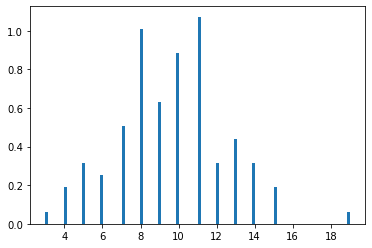

In [5]:
count, bins, ignored = plt.hist(job_time_interval, 100, density = True)
plt.show()

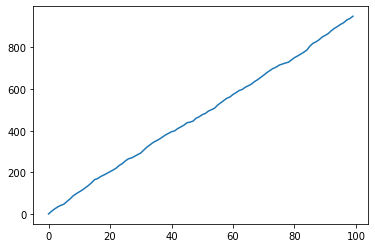

In [6]:
plt.plot(job_create_time)
plt.show()

# Job Queue

In [7]:
class JobQueue(object):
    
    def __init__(self):
        self.job_q = queue.Queue()
        self.job_number = 0
        
    def insertJob(self, inout,  station_dest):
        job = {"inout": inout, "station_dest": station_dest}
        self.job_q.put(job)
        self.job_number+=1

    def getJob(self):
        if self.job_q.empty():
            return 
        self.job_number-=1
        return self.job_q.get()

In [8]:
def job_create(rack_location,total_job_location_list,time,total_job_information):
    job_location = [random.choice(rack_location)]
    if total_job_location_list.count(job_location)%2==0:
        total_job_information['{}'.format(time)] = ['in',job_location]
    else:
        total_job_information['{}'.format(time)] = ['out',job_location]
    total_job_location_list.append(job_location)
    return total_job_information

# AGV

In [9]:
class AGV(object):
    max_battery = 400
    CHARGING_STATION = [(2,9),(6,9)]    
    
    def __init__(self,agv_id,current_location,job_for_bid,current_tick=0,cost=0,bid_list = []):
        self.agv_id = agv_id
        self.battery = self.max_battery
        self.current_location = current_location
        self.job = None
        self.destination = None
        self.available = True
        self.current_tick = current_tick
        self.to_chaging_station = False
        self.charging = False
        self.job_for_bid = job_for_bid
        self.bid_list = bid_list
        self.cost = cost 
        
#     def __str__(self):
#         return 'agv_id:{}  job:{}  available:{}'.format(self.agv_id, self.job, self.available)
    
    def __str__(self):
        return 'agv_id:{}'.format(self.agv_id)
    
    def move_one_tick(self):
        if len(self.path) !=0:
            self.next_location = self.path[0]
            self.current_location = self.next_location
            del self.path[0]
            if len(self.path) ==0:
                self.available = True
            self.battery -=1
            self.current_tick +=1
        else:
            self.available = True
            
    def move_one_tick_for_charge(self):
        if len(self.path_for_charge) !=0:
            self.to_chaging_station = True
            self.next_location = self.path_for_charge[0]
            self.current_location = self.next_location
            del self.path_for_charge[0]
            self.battery -=1
            self.current_tick +=1
            if len(self.path_for_charge) ==0:
                self.to_chaging_station = False
                self.charging = True
                self.charging_agv()
        else:
            self.charging = True
    
    def get_job(self,job,astar_path):
        self.job = job
        self.path = astar_path
        self.available = False
        
    def go_to_charge(self,astar_path_to_charger):
        self.path_for_charge = astar_path_to_charger
        self.to_chaging_station = True
    
    
#     def agv_to_charging_station(self,battery_threshold):
#         if self.available == True and self.battery <= battery_threshold:
#             self.to_chaging_station = True

    def calculate_bid(self,job,warehouse,INPUT_STATION,OUTPUT_STATION):
        if job['inout']=='in':
            cost = len(astar(warehouse,agv.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']]))
        else:
            cost = len(astar(warehouse,agv.current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION))
        self.cost= cost 
        return self,cost,self.agv_id
    
#     def calculate_cost_for_charing_bid(self,warehouse,CHARGING_STATION):
#         bid_for_charge = []
#         for charging_station in CHARGING_STATION:
#             bid_for_charge.append(charging_station,astar(warehouse,self.current_location,charging_station))
#         bid_for_charge_sort = sorted(bid_for_charge, key =lambda x:x[1])
#         selected_chargeing
#         return cost        
    
    
    def select_charging_station(self,warehouse,CHARGING_STATION):
        bid_for_charge = []
        for charging_station in CHARGING_STATION:
            bid_for_charge.append(charging_station,astar(warehouse,self.current_location,charging_station))
        bid_for_charge_sort = sorted(bid_for_charge, key =lambda x:x[1])
        selected_charging_station = bid_for_charge_sort[0][0]
        astar_path_to_charger = bid_for_charge_sort[0][1]
        return selected_charging_station, astar_path_to_charger   
    
    def charging_agv(self):
        if self.charging == True:
            self.battery +=10
            if self.battery >= self.max_battery:
                self.battery = self.max_battery
                self.charging = False 
                self.available=True
#                 
                
    def send_bid(self,avail_agv_list):
        for agv_ in avail_agv_list:
            agv_.bid_list.append((self,agv.agv_id,agv.cost))
            
#     def win_bid(self)
        
    
    def drop_job(self):
        self.job = None
        self.available = True
        
    def clear_bid_list(self,agv_list):
        for agv in agv_list:
            agv.bid_list = []


In [10]:
def getAvailAGV(AGV_LIST,battery_threshold):
    return [agv for agv in AGV_LIST if agv.available == True and agv.battery > battery_threshold]

In [11]:
def getNeedChargeAgv(AGV_LIST,battery_threshold):
    return [agv for agv in AGV_LIST if agv.charging == True and agv.battery <= battery_threshold and agv.charging == False and agv.to_chaging_station == False]

In [12]:
def getChargingAGV(AGV_LIST):
    return [agv for agv in AGV_LIST if agv.charging == True]

# Astar

In [13]:
class node:
    def __init__(self,parent=None, position = None):
        self.parent = parent
        self.position = position
        self.g = 0
        self.h = 0
        self.f = 0
    def __eq__(self,other):
        return self.position == other.position

In [14]:
def manhattan_distance(start_node,goal_node):
    dx = abs(start_node[0]-goal_node[0])
    dy = abs(start_node[1]-goal_node[1])
    return dx + dy

In [15]:
def astar(graph,start,goal):
    start_node = node(None,(start[1],start[0]))
    goal_node = node(None,(goal[1],goal[0]))
    open_list = []
    closed_list = []
    graph = [el for el in graph][::-1]
#     for i in graph:
#         print(i)
    
    open_list.append(start_node)
    while open_list:
        current_node = open_list[0]
        current_index = 0
        
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index
        open_list.pop(current_index)
        closed_list.append(current_node)
        
        if current_node == goal_node:
            path = []
            current = current_node
            while current is not None:
#                 x,y = current.position
#                 graph[x][y] = 9
                path.append((current.position[1],current.position[0]))
                current = current.parent
                
            return path[::-1]
        
        children = []
        for new_position in [(0,1),(1,0),(-1,0),(0,-1)]:
            node_position = (current_node.position[0]+new_position[0],
                             current_node.position[1]+new_position[1])
            within_range = [
                node_position[1]>len(graph)-1,
                node_position[1]<0,
                node_position[0]>len(graph[len(graph)-1])-1,
                node_position[0]<0]
            if any(within_range):
                continue
            if graph[node_position[0]][node_position[1]] !=0:
                continue
            
            new_node = node(current_node, node_position)
            children.append(new_node)
        
        for child in children:
            if child in closed_list:
                continue
            child.g = current_node.g+1
            child.h = manhattan_distance(child.position,goal_node.position)
            child.f = child.g + child.h
            
            if len([open_node for open_node in open_list
                   if child == open_node and child.g>open_node.g]) > 0:
                continue
            open_list.append(child)

# Warehouse, Rack, Charging_station

In [16]:
def make_warehouse(row,col):
    warehouse = [[0]*col for i in range(row)]
    return warehouse 

In [17]:
def set_rack(warehouse,rack_location):
    for idx, row in enumerate(warehouse):
        warehouse[idx] =  [1 if (ix, ROW -1 - idx) in rack_location else 0 for ix,col in enumerate(warehouse[idx])]

In [18]:
def get4Ways(point):
    return [(point[0],point[1]+1), (point[0]+1,point[1]),
            (point[0],point[1]-1), (point[0]-1,point[1])]

In [19]:
def set_charging_station(warehouse,CHARGING_STATION,ROW,COL):
    for charging_spot in CHARGING_STATION:
        warehouse[ROW-1-charging_spot[1]][charging_spot[0]]=2
    return warehouse

# Make warehouse, Rack, Rack enterence, Station

In [20]:
ROW, COL = 10,10
warehouse = make_warehouse(ROW,COL)
INPUT_STATION = (3,0)
OUTPUT_STATION = (6,0)
CHARGING_STATION = [(2,9),(7,9)]   
rack_location =  [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7),
                  (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), 
                  (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), 
                  (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), 
                  (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), 
                  (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]


In [21]:
set_rack(warehouse,rack_location)
# set_charging_station(warehouse,CHARGING_STATION,ROW,COL)

In [22]:
Rack_enterence={}
for point in rack_location:
    four_ways = get4Ways(point)
    neighbour_obstacle_list = [way for way in four_ways if way in rack_location]  ## 좌표정보 ex) (1,3), (2,2)....
    neighbour_empty_list = [way for way in four_ways if way not in rack_location] 
    if len(neighbour_empty_list) == 1: ### 모서리 아님
        Rack_enterence[point] = neighbour_empty_list[0]
    elif len(neighbour_empty_list) == 2: ### 모서리임
        obstacle_way_list = [four_ways.index(obst) for obst in neighbour_obstacle_list]  ## 방향정보 ex) 0,1, 2...
        for idx, obst_point in enumerate(neighbour_obstacle_list):
            obst_way = obstacle_way_list[idx]
            obst_plus1_point = get4Ways(obst_point)[obst_way]
            if obst_plus1_point in rack_location:
                continue
            else:
                Rack_enterence[point] = four_ways[obst_way-2]
    else:
        print('ERROR finding obstacle/entrance for RACK {}'.format(point))

# 실험

### Simulation condition

In [23]:
jobQ = JobQueue()
jobQ_for_simulation = JobQueue()
run_time = 2000
total_job_location_list = []
select_agv = []
charging_agvs = []
moving_for_charge_agvs = []
battery_threshold = 100
total_job_information = {}

### Created Job 확인

In [24]:
for time in range(run_time+1):
    if time in job_create_time:
        job_create(rack_location,total_job_location_list,time,total_job_information)
print(total_job_information)
print(len(total_job_information))

{'0': ['in', [(8, 2)]], '13': ['in', [(1, 3)]], '24': ['in', [(5, 7)]], '34': ['in', [(7, 3)]], '41': ['out', [(8, 2)]], '47': ['in', [(1, 1)]], '60': ['in', [(2, 7)]], '72': ['in', [(7, 2)]], '87': ['in', [(7, 4)]], '97': ['in', [(4, 4)]], '106': ['in', [(8, 7)]], '115': ['in', [(2, 4)]], '126': ['out', [(1, 3)]], '137': ['in', [(7, 6)]], '150': ['out', [(7, 4)]], '165': ['in', [(4, 7)]], '170': ['in', [(1, 5)]], '180': ['in', [(4, 2)]], '187': ['in', [(5, 3)]], '195': ['in', [(1, 3)]], '203': ['in', [(5, 6)]], '211': ['in', [(2, 2)]], '220': ['in', [(8, 4)]], '233': ['in', [(5, 2)]], '242': ['in', [(5, 4)]], '255': ['out', [(5, 6)]], '265': ['in', [(4, 5)]], '269': ['in', [(4, 3)]], '277': ['out', [(7, 2)]], '285': ['in', [(2, 5)]], '293': ['in', [(4, 6)]], '307': ['out', [(5, 3)]], '321': ['out', [(2, 2)]], '332': ['in', [(7, 2)]], '343': ['out', [(4, 2)]], '351': ['in', [(7, 1)]], '359': ['in', [(8, 5)]], '369': ['out', [(5, 4)]], '379': ['out', [(1, 3)]], '387': ['in', [(8, 3)]], 

### Create AGV

In [25]:
agv1 = AGV("agv1",(0,9),[])
agv2 = AGV("agv2",(3,9),[])
agv3 = AGV("agv3",(6,9),[])
agv4 = AGV("agv4",(9,9),[])
AGV_LIST = [agv1,agv2,agv3,agv4]
AGV_LIST

### Exercise

In [26]:
# job = {'inout': 'in', 'station_dest': (8, 2)}
# print(job['inout'])

In [27]:
# Rack_enterence[job['station_dest']]

In [28]:
# jobQ.insertJob(job['inout'],job['station_dest'])

In [29]:
# agv1 = AGV("agv1",(9,9),job,400)
# # agv2 = AGV("agv2",(3,9),job,500)
# agv3 = AGV("agv3",(0,9),job,300)
# agv4 = AGV("agv4",(0,9),job,700)
# AGV_LIST = [agv1,agv3,agv4]
# AGV_LIST

In [30]:
# agv_avail = getAvailAGV(AGV_LIST, battery_threshold)
# print(agv_avail)
# print(len(agv_avail))

In [31]:
# ##0720만들음
# while len(agv_avail)!=0 and jobQ.job_number!=0:
#     job = jobQ.getJob()
#     agv_avail = getAvailAGV(AGV_LIST, battery_threshold)
#     for agv in agv_avail:
# #         print(agv)
#         agv.calculate_bid(job,warehouse,INPUT_STATION,OUTPUT_STATION)
#         agv.bid_list.append(agv.calculate_bid(job,warehouse,INPUT_STATION,OUTPUT_STATION))
#     for agv_ in agv_avail:
#         agv_bid_sort = sorted(agv_.bid_list,key = lambda x:x[1], reverse = False)
# #         print(agv_bid_sort)
#     bid_compare_battery=[]
#     for i in range(len(agv_bid_sort)):
#         if agv_bid_sort[i][1]==agv_bid_sort[0][1]:
#             bid_compare_battery.append((agv_bid_sort[i]))
#     bid_compare_battery_sort = sorted(bid_compare_battery, key= lambda x:x[0].battery, reverse =True)
# #     print('0',type(bid_compare_battery_sort[0][0]))
#     if job['inout']=='in':
#         astar_path = astar(warehouse,bid_compare_battery_sort[0][0].current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']])
#     else:
#         astar_path = astar(warehouse,bid_compare_battery_sort[0][0].current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION)
#     bid_compare_battery_sort[0][0].get_job(job,astar_path)
#     for agv in AGV_LIST:
#         agv.clear_bid_list(AGV_LIST)
    


### Main 함수 

In [33]:
#7월 20 일
if __name__ =='__main__':
    for running_time in range(run_time+1):
        print('charging_agv',getChargingAGV(AGV_LIST))
        if len(moving_for_charge_agvs)!=0:
            for moving_agvs in moving_for_charge_agvs:
                moving_agvs.move_one_tick_for_charge()
                print("running time : {}, moving agv for charging : {}, current location : {}".format(running_time, moving_agvs,moving_agvs.current_location))
                if moving_agvs.charging == True:
                    moving_agvs.
                    moving_for_charge_agvs.remove(moving_agvs)
                    charging_agvs.append(moving_agvs)

        agv_need_charge = getNeedChargeAgv(AGV_LIST,battery_threshold) 
        if len(agv_need_charge)==0:
            print('A time : {}, There is no new AGVs for charge'.format(running_time))
        else:
            print('B There is new AGVs for charging {}'.format(agv_need_charge))          
            for agv_for_charge in agv_need_charge:
                bid_for_charge_list = []
                for charger in CHARGING_STATION:
                    bid_for_charge_list.append(agv_for_charge.calculate_cost_for_charing_bid(warehouse,charger))
                min_charger_bid = min(bid_for_charge_list)
                target_charger = CHARGING_STATION[bid_for_charge_list.index(min_charger_bid)]
                astar_path_to_charger = astar(warehouse,agv_for_charge.current_location,target_charger)
                agv_for_charge.go_to_charge(astar_path_to_charger)
                moving_for_charge_agvs.append(agv_for_charge)      
    #         print("###",moving_for_charge_agvs)

    #       #사용가능한 agv와 job이 있을때 
        if running_time in job_create_time:
            print("@@@@@@@@@@@@@@@@@",running_time)
            jobQ.insertJob(total_job_information.get('{}'.format(running_time))[0],total_job_information.get('{}'.format(running_time))[1][0])
            agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
            print('C running_time : {} , agv_avail : {}'.format(running_time,agv_avail))
            if len(agv_avail)!=0 and jobQ.job_number !=0:
    #             print(len(agv_avail),jobQ.job_number)
                while len(agv_avail)!=0 and jobQ.job_number!=0:
                    job = jobQ.getJob()
                    print(job)
                    agv_avail = getAvailAGV(AGV_LIST, battery_threshold)
                    for agv in agv_avail:
                #         print(agv)
                        agv.calculate_bid(job,warehouse,INPUT_STATION,OUTPUT_STATION)
                        agv.bid_list.append(agv.calculate_bid(job,warehouse,INPUT_STATION,OUTPUT_STATION))
                    for agv_ in agv_avail:
                        agv_bid_sort = sorted(agv_.bid_list,key = lambda x:x[1], reverse = False)
                #         print(agv_bid_sort)
                    bid_compare_battery=[]
                    for i in range(len(agv_bid_sort)):
                        if agv_bid_sort[i][1]==agv_bid_sort[0][1]:
                            bid_compare_battery.append((agv_bid_sort[i]))
                    bid_compare_battery_sort = sorted(bid_compare_battery, key= lambda x:x[0].battery, reverse =True)
                #     print('0',type(bid_compare_battery_sort[0][0]))
                    if job['inout']=='in':
                        astar_path = astar(warehouse,bid_compare_battery_sort[0][0].current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']])
                    else:
                        astar_path = astar(warehouse,bid_compare_battery_sort[0][0].current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION)
                    target_agv = bid_compare_battery_sort[0][0]
                    select_agv.append(target_agv)
                    bid_compare_battery_sort[0][0].get_job(job,astar_path)
                    print("D running_time : {}, target_agv : {}, target_agv.battery: {}, destination : {}, astar_path : {}, available:{}".format(running_time,target_agv,target_agv.battery,job['station_dest'],astar_path,target_agv.available))
                    for agv in AGV_LIST:
                        agv.clear_bid_list(AGV_LIST)

                    for moving_agv in set(select_agv):
                        moving_agv.move_one_tick()
                    if len(moving_agv.path)==0:
                        select_agv.remove(moving_agv)
                    print("E time : {}, moving agv : {}, battery : {}, current location : {}".format(running_time,moving_agv,moving_agv.battery,moving_agv.current_location))

            else:
                for moving_agv in select_agv:
                    moving_agv.move_one_tick()
                    if len(moving_agv.path)==0:
                        select_agv.remove(moving_agv)
                    print("F",running_time,moving_agv,moving_agv.battery,moving_agv.current_location)            


    # #         elif len(agv_avail) == 0 and jobQ.job_number = 0  # move one tick 
    # #         elif len(agv_avail) == 0 and jobQ.job_number !=0  # move one tick 
    # #         elif len(agv_avail) !=0 and jobQ.job_number = 0   # move one tick 

        else:
            agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
            if len(agv_avail)!=0 and jobQ.job_number !=0:
                while len(agv_avail)!=0 and jobQ.job_number!=0:
                    job = jobQ.getJob()
                    print(job)
                    agv_avail = getAvailAGV(AGV_LIST, battery_threshold)
                    for agv in agv_avail:
                #         print(agv)
                        agv.calculate_bid(job,warehouse,INPUT_STATION,OUTPUT_STATION)
                        agv.bid_list.append(agv.calculate_bid(job,warehouse,INPUT_STATION,OUTPUT_STATION))
                    for agv_ in agv_avail:
                        agv_bid_sort = sorted(agv_.bid_list,key = lambda x:x[1], reverse = False)
                #         print(agv_bid_sort)
                    bid_compare_battery=[]
                    for i in range(len(agv_bid_sort)):
                        if agv_bid_sort[i][1]==agv_bid_sort[0][1]:
                            bid_compare_battery.append((agv_bid_sort[i]))
                    bid_compare_battery_sort = sorted(bid_compare_battery, key= lambda x:x[0].battery, reverse =True)
                #     print('0',type(bid_compare_battery_sort[0][0]))
                    if job['inout']=='in':
                        astar_path = astar(warehouse,bid_compare_battery_sort[0][0].current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']])
                    else:
                        astar_path = astar(warehouse,bid_compare_battery_sort[0][0].current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION)
                    target_agv = bid_compare_battery_sort[0][0]
                    select_agv.append(target_agv)
                    bid_compare_battery_sort[0][0].get_job(job,astar_path)
                    print("G running_time : {}, target_agv : {}, target_agv.battery: {}, destination : {}, astar_path : {}, available:{}".format(running_time,target_agv,target_agv.battery,job['station_dest'],astar_path,target_agv.available))
                for moving_agvs in set(select_agv):
                    moving_agvs.move_one_tick()
                    print("H running time : {} ,moving agvs : {} ,agv battery : {}, moving agv location : {}, agv available{}".format(running_time,moving_agvs, moving_agvs.battery, moving_agvs.current_location, moving_agvs.available))
                    if len(moving_agvs.path) ==0:
                        select_agv.remove(moving_agvs)
        #             print("@@@@",moving_agvs,moving_agv.battery,moving_agv.current_location)

            else:
                for moving_agvs in set(select_agv):
                    moving_agvs.move_one_tick()
                    print("I running time : {} ,moving agvs : {} ,agv battery : {}, moving agv location : {}, agv available{}".format(running_time,moving_agvs, moving_agvs.battery, moving_agvs.current_location, moving_agvs.available))
                    if len(moving_agvs.path) ==0:
                        select_agv.remove(moving_agvs)       

charging_agv []
A time : 0, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 0
C running_time : 0 , agv_avail : [<__main__.AGV object at 0x000001C432A74F70>, <__main__.AGV object at 0x000001C432A74760>, <__main__.AGV object at 0x000001C432A74940>, <__main__.AGV object at 0x000001C432A74610>]
{'inout': 'in', 'station_dest': (8, 2)}
D running_time : 0, target_agv : agv_id:agv2, target_agv.battery: 400, destination : (8, 2), astar_path : [(3, 9), (3, 8), (3, 7), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (9, 2)], available:False
E time : 0, moving agv : agv_id:agv2, battery : 399, current location : (3, 9)
charging_agv []
A time : 1, There is no new AGVs for charge
I running time : 1 ,moving agvs : agv_id:agv2 ,agv battery : 398, moving agv location : (3, 8), agv availableFalse
charging_agv []
A time : 2, There is no new AGVs for charge
I running time : 2 ,moving agvs : agv_id:agv2 ,agv battery : 397, moving agv

A time : 242, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 242
C running_time : 242 , agv_avail : [<__main__.AGV object at 0x000001C432A74F70>, <__main__.AGV object at 0x000001C432A74760>, <__main__.AGV object at 0x000001C432A74940>, <__main__.AGV object at 0x000001C432A74610>]
{'inout': 'in', 'station_dest': (5, 4)}
D running_time : 242, target_agv : agv_id:agv4, target_agv.battery: 215, destination : (5, 4), astar_path : [(9, 4), (9, 3), (9, 2), (9, 1), (9, 0), (8, 0), (7, 0), (6, 0), (5, 0), (4, 0), (3, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4)], available:False
E time : 242, moving agv : agv_id:agv4, battery : 214, current location : (9, 4)
charging_agv []
A time : 243, There is no new AGVs for charge
I running time : 243 ,moving agvs : agv_id:agv4 ,agv battery : 213, moving agv location : (9, 3), agv availableFalse
charging_agv []
A time : 244, There is no new AGVs for charge
I running time : 244 ,moving agvs : agv_id:agv4 ,agv battery : 212, moving a

A time : 505, There is no new AGVs for charge
I running time : 505 ,moving agvs : agv_id:agv2 ,agv battery : 280, moving agv location : (6, 0), agv availableTrue
I running time : 505 ,moving agvs : agv_id:agv1 ,agv battery : 358, moving agv location : (2, 0), agv availableFalse
charging_agv []
A time : 506, There is no new AGVs for charge
I running time : 506 ,moving agvs : agv_id:agv1 ,agv battery : 357, moving agv location : (1, 0), agv availableFalse
charging_agv []
A time : 507, There is no new AGVs for charge
I running time : 507 ,moving agvs : agv_id:agv1 ,agv battery : 356, moving agv location : (0, 0), agv availableFalse
charging_agv []
A time : 508, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 508
C running_time : 508 , agv_avail : [<__main__.AGV object at 0x000001C432A74760>]
{'inout': 'out', 'station_dest': (8, 7)}
D running_time : 508, target_agv : agv_id:agv2, target_agv.battery: 280, destination : (8, 7), astar_path : [(6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (9, 2), 

charging_agv []
A time : 787, There is no new AGVs for charge
@@@@@@@@@@@@@@@@@ 787
C running_time : 787 , agv_avail : []
F 787 agv_id:agv1 135 (6, 4)
F 787 agv_id:agv1 134 (6, 3)
charging_agv []
A time : 788, There is no new AGVs for charge
I running time : 788 ,moving agvs : agv_id:agv1 ,agv battery : 133, moving agv location : (6, 2), agv availableFalse
charging_agv []
A time : 789, There is no new AGVs for charge
I running time : 789 ,moving agvs : agv_id:agv1 ,agv battery : 132, moving agv location : (6, 1), agv availableFalse
charging_agv []
A time : 790, There is no new AGVs for charge
I running time : 790 ,moving agvs : agv_id:agv1 ,agv battery : 131, moving agv location : (6, 0), agv availableTrue
charging_agv []
A time : 791, There is no new AGVs for charge
{'inout': 'out', 'station_dest': (7, 1)}
G running_time : 791, target_agv : agv_id:agv1, target_agv.battery: 131, destination : (7, 1), astar_path : [(6, 0), (6, 1), (6, 1), (6, 0)], available:False
H running time : 791 ,m

charging_agv []
A time : 1231, There is no new AGVs for charge
charging_agv []
A time : 1232, There is no new AGVs for charge
charging_agv []
A time : 1233, There is no new AGVs for charge
charging_agv []
A time : 1234, There is no new AGVs for charge
charging_agv []
A time : 1235, There is no new AGVs for charge
charging_agv []
A time : 1236, There is no new AGVs for charge
charging_agv []
A time : 1237, There is no new AGVs for charge
charging_agv []
A time : 1238, There is no new AGVs for charge
charging_agv []
A time : 1239, There is no new AGVs for charge
charging_agv []
A time : 1240, There is no new AGVs for charge
charging_agv []
A time : 1241, There is no new AGVs for charge
charging_agv []
A time : 1242, There is no new AGVs for charge
charging_agv []
A time : 1243, There is no new AGVs for charge
charging_agv []
A time : 1244, There is no new AGVs for charge
charging_agv []
A time : 1245, There is no new AGVs for charge
charging_agv []
A time : 1246, There is no new AGVs for

charging_agv []
A time : 1814, There is no new AGVs for charge
charging_agv []
A time : 1815, There is no new AGVs for charge
charging_agv []
A time : 1816, There is no new AGVs for charge
charging_agv []
A time : 1817, There is no new AGVs for charge
charging_agv []
A time : 1818, There is no new AGVs for charge
charging_agv []
A time : 1819, There is no new AGVs for charge
charging_agv []
A time : 1820, There is no new AGVs for charge
charging_agv []
A time : 1821, There is no new AGVs for charge
charging_agv []
A time : 1822, There is no new AGVs for charge
charging_agv []
A time : 1823, There is no new AGVs for charge
charging_agv []
A time : 1824, There is no new AGVs for charge
charging_agv []
A time : 1825, There is no new AGVs for charge
charging_agv []
A time : 1826, There is no new AGVs for charge
charging_agv []
A time : 1827, There is no new AGVs for charge
charging_agv []
A time : 1828, There is no new AGVs for charge
charging_agv []
A time : 1829, There is no new AGVs for

In [ ]:
# for running_time in range(run_time+1):
#     if len(moving_for_charge_agvs)!=0:
#         for moving_agvs in moving_for_charge_agvs:
#             moving_agvs.move_one_tick_for_charge()
#             print("running time : {}, moving agv for charging : {}, current location : {}".format(running_time, moving_agvs,moving_agvs.current_location))
#             if moving_agvs.charging == True:
#                 moving_for_charge_agvs.remove(moving_agvs)
                
#     agv_need_charge = getNeedChargeAgv(AGV_LIST,battery_threshold) 
#     if len(agv_need_charge)==0:
#         print('A time : {}, There is no new AGVs for charge'.format(running_time))
#     else:
#         print('B There is new AGVs for charging {}'.format(agv_need_charge))          
#         for agv_for_charge in agv_need_charge:
#             bid_for_charge_list = []
#             for charger in CHARGING_STATION:
#                 bid_for_charge_list.append(agv_for_charge.calculate_cost_for_charing_bid(warehouse,charger))
#             min_charger_bid = min(bid_for_charge_list)
#             target_charger = CHARGING_STATION[bid_for_charge_list.index(min_charger_bid)]
#             astar_path_to_charger = astar(warehouse,agv_for_charge.current_location,target_charger)
#             agv_for_charge.go_to_charge(astar_path_to_charger)
#             moving_for_charge_agvs.append(agv_for_charge) 
            
#     if running_time in job_create_time:
#         jobQ.insertJob(total_job_information.get('{}'.format(running_time))[0],total_job_information.get('{}'.format(running_time))[1][0])
#         agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
#         while len(agv_avail)!=0 and jobQ.job_numer !=0:
#             job = jobQ.getJob()
#             for agv in agv_avail:
#                 agv.calculate_bid()

In [ ]:
# for running_time in range(run_time+1):
#     if len(moving_for_charge_agvs)!=0:
#         for moving_agvs in moving_for_charge_agvs:
#             moving_agvs.move_one_tick_for_charge()
#             print("running time : {}, moving agv for charging : {}, current location : {}".format(running_time, moving_agvs,moving_agvs.current_location))
#             if moving_agvs.charging == True:
#                 moving_for_charge_agvs.remove(moving_agvs)
                
#     agv_need_charge = getNeedChargeAgv(AGV_LIST,battery_threshold) 
#     if len(agv_need_charge)==0:
#         print('A time : {}, There is no new AGVs for charge'.format(running_time))
#     else:
#         print('B There is new AGVs for charging {}'.format(agv_need_charge))          
#         for agv_for_charge in agv_need_charge:
#             bid_for_charge_list = []
#             for charger in CHARGING_STATION:
#                 bid_for_charge_list.append(agv_for_charge.calculate_cost_for_charing_bid(warehouse,charger))
#             min_charger_bid = min(bid_for_charge_list)
#             target_charger = CHARGING_STATION[bid_for_charge_list.index(min_charger_bid)]
#             astar_path_to_charger = astar(warehouse,agv_for_charge.current_location,target_charger)
#             agv_for_charge.go_to_charge(astar_path_to_charger)
#             moving_for_charge_agvs.append(agv_for_charge)      
# #         print("###",moving_for_charge_agvs)
                    
# #       #사용가능한 agv와 job이 있을때 
#     if running_time in job_create_time:
#         print("@@@@@@@@@@@@@@@@@",running_time)
#         jobQ.insertJob(total_job_information.get('{}'.format(running_time))[0],total_job_information.get('{}'.format(running_time))[1][0])
#         agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
#         print('C running_time : {} , agv_avail : {}'.format(running_time,agv_avail))
#         if len(agv_avail)!=0 and jobQ.job_number !=0:
#             if running_time ==0 or len(select_agv)==0:
#                 auctioneer = random.choice(agv_avail)
#             job = jobQ.getJob()
            
#             bid_list = []
#             for agv in agv_avail:
#                 bid_list.append(agv.calculate_bid(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
#             min_bid = min(bid_list)
#             target_agv = agv_avail[bid_list.index(min_bid)]
#             if job['inout']=='in':
#                 astar_path = astar(warehouse,target_agv.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']])
#             else:
#                 astar_path = astar(warehouse,target_agv.current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION)
#             target_agv.get_job(job,astar_path)
#             select_agv.append(target_agv)
#             print("D running_time : {}, target_agv : {}, target_agv.battery: {}, destination : {}, astar_path : {}, available:{}".format(running_time,target_agv,target_agv.battery,job['station_dest'],astar_path,target_agv.available))
#     #           print(auctioneer)
#             for moving_agv in set(select_agv):
#                 moving_agv.move_one_tick()
#                 if len(moving_agv.path)==0:
#                     select_agv.remove(moving_agv)
#                 print("E time : {}, moving agv : {}, battery : {}, current location : {}".format(running_time,moving_agv,moving_agv.battery,moving_agv.current_location))
#         else:
#             for moving_agv in select_agv:
#                 moving_agv.move_one_tick()
#                 if len(moving_agv.path)==0:
#                     select_agv.remove(moving_agv)
#                 print("F",running_time,moving_agv,moving_agv.battery,moving_agv.current_location)            
   
                
# # #         elif len(agv_avail) == 0 and jobQ.job_number = 0  # move one tick 
# # #         elif len(agv_avail) == 0 and jobQ.job_number !=0  # move one tick 
# # #         elif len(agv_avail) !=0 and jobQ.job_number = 0   # move one tick 
                    
#     else:
#         agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
#         if len(agv_avail)!=0 and jobQ.job_number !=0:
#             job = jobQ.getJob()
#             bid_list = []
#             for agv in agv_avail:
#                 bid_list.append(agv.calculate_bid(agv,job,warehouse,INPUT_STATION,OUTPUT_STATION))
#             min_bid = min(bid_list)
#             target_agv = agv_avail[bid_list.index(min_bid)]
#             if job['inout']=='in':
#                 astar_path = astar(warehouse,target_agv.current_location,INPUT_STATION)+astar(warehouse,INPUT_STATION,Rack_enterence[job['station_dest']])
#             else:
#                 astar_path = astar(warehouse,target_agv.current_location,Rack_enterence[job['station_dest']])+astar(warehouse,Rack_enterence[job['station_dest']],OUTPUT_STATION)
#             target_agv.get_job(job,astar_path)
#             select_agv.append(target_agv)
#             print("G running_time : {}, target_agv : {}, target_agv.battery: {}, destination : {}, astar_path : {}, available:{}".format(running_time,target_agv,target_agv.battery,job['station_dest'],astar_path,target_agv.available))
#             for moving_agvs in set(select_agv):
#                 moving_agvs.move_one_tick()
#                 print("H running time : {} ,moving agvs : {} ,agv battery : {}, moving agv location : {}, agv available{}".format(running_time,moving_agvs, moving_agvs.battery, moving_agvs.current_location, moving_agvs.available))
#                 if len(moving_agvs.path) ==0:
#                     select_agv.remove(moving_agvs)
#     #             print("@@@@",moving_agvs,moving_agv.battery,moving_agv.current_location)
        
#         else:
#             for moving_agvs in set(select_agv):
#                 moving_agvs.move_one_tick()
#                 print("I running time : {} ,moving agvs : {} ,agv battery : {}, moving agv location : {}, agv available{}".format(running_time,moving_agvs, moving_agvs.battery, moving_agvs.current_location, moving_agvs.available))
#                 if len(moving_agvs.path) ==0:
#                     select_agv.remove(moving_agvs)       